In [1]:
import os
import cv2
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
# !pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
# import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
# from tensorflow.keras.optimizers import *
# from tensorflow.keras.utils import plot_model, to_categorical   
# from tensorflow.keras.layers.experimental import preprocessing
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


In [2]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# # days start interval
# SURVIVAL_CATEGORIES= {
#     'SHORT' : 0 , # 0-300
#     'MEDIUM' : 250,  # 300-450
#     'LONG' : 450, # 450 and more
# }

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128
TRAIN_DATASET_PATH='./MICCAI_BraTS2020_TrainingData/'
VAL_DATASET_PATH='./MICCAI_BraTS2020_ValidationData/'

In [3]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
train_and_val_directories+= [f.path for f in os.scandir(VAL_DATASET_PATH) if f.is_dir()]
# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories)

In [4]:
print(train_and_val_directories)

['./MICCAI_BraTS2020_TrainingData/BraTS20_Training_001', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_002', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_003', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_004', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_005', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_006', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_007', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_008', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_009', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_010', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_011', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_012', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_013', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_014', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_015', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_016', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_017', './MICCAI_BraTS2020_TrainingData/BraTS20_Traini

In [5]:
import csv

csvs = [r'MICCAI_BraTS2020_TrainingData\survival_info.csv', r'MICCAI_BraTS2020_ValidationData\survival_evaluation.csv']

age_dict = {}
days_dict = {}
at_line = 0
category_short = 0
category_medium = 0
category_long = 0
max_days = 0
for csv_path in csvs:
    with open(csv_path, mode='r') as csv_file:
        csv_reader = csv.reader(csv_file,delimiter = ',')
    #  row_count = sum(1 for row in csv_reader)
    #   print(f'total rows: {row_count} .')
        for row in csv_reader:
            if at_line == 0:
                print(f'Column names are {", ".join(row)}')
                at_line += 1
            else:
                if (row[-1] != "GTR"):
                    continue
                print(row)
                key = row[0]
                age = row[1]
                days = row[2]
                age_dict[key] = float(age)
                if (not days.isnumeric()):
                    continue
                days_dict[key] = int(days)
                max_days = max(max_days,int(days))
                if int(days) < 250:
                    category_short += 1
                elif (int(days) >= 250 and int(days) <= 450):
                    category_medium += 1
                else:
                    category_long += 1
                at_line+=1

    print(f'Processed {at_line} lines.')
    print(category_short,category_medium,category_long)
    print(max_days)

Column names are Brats20ID, Age, Survival_days, Extent_of_Resection
['BraTS20_Training_001', '60.463', '289', 'GTR']
['BraTS20_Training_002', '52.263', '616', 'GTR']
['BraTS20_Training_003', '54.301', '464', 'GTR']
['BraTS20_Training_004', '39.068', '788', 'GTR']
['BraTS20_Training_005', '68.493', '465', 'GTR']
['BraTS20_Training_006', '67.126', '269', 'GTR']
['BraTS20_Training_007', '69.912', '503', 'GTR']
['BraTS20_Training_009', '56.419', '1155', 'GTR']
['BraTS20_Training_010', '48.367', '515', 'GTR']
['BraTS20_Training_012', '65.899', '495', 'GTR']
['BraTS20_Training_013', '59.693', '698', 'GTR']
['BraTS20_Training_014', '51.734', '359', 'GTR']
['BraTS20_Training_015', '62.614', '169', 'GTR']
['BraTS20_Training_016', '55.759', '368', 'GTR']
['BraTS20_Training_017', '58.258', '439', 'GTR']
['BraTS20_Training_018', '61.605', '486', 'GTR']
['BraTS20_Training_019', '68.049', '287', 'GTR']
['BraTS20_Training_021', '56.921', '576', 'GTR']
['BraTS20_Training_022', '44.162', '350', 'GTR']


In [6]:
age_dict

{'BraTS20_Training_001': 60.463,
 'BraTS20_Training_002': 52.263,
 'BraTS20_Training_003': 54.301,
 'BraTS20_Training_004': 39.068,
 'BraTS20_Training_005': 68.493,
 'BraTS20_Training_006': 67.126,
 'BraTS20_Training_007': 69.912,
 'BraTS20_Training_009': 56.419,
 'BraTS20_Training_010': 48.367,
 'BraTS20_Training_012': 65.899,
 'BraTS20_Training_013': 59.693,
 'BraTS20_Training_014': 51.734,
 'BraTS20_Training_015': 62.614,
 'BraTS20_Training_016': 55.759,
 'BraTS20_Training_017': 58.258,
 'BraTS20_Training_018': 61.605,
 'BraTS20_Training_019': 68.049,
 'BraTS20_Training_021': 56.921,
 'BraTS20_Training_022': 44.162,
 'BraTS20_Training_023': 67.833,
 'BraTS20_Training_024': 46.666,
 'BraTS20_Training_028': 76.367,
 'BraTS20_Training_033': 67.86,
 'BraTS20_Training_034': 46.452,
 'BraTS20_Training_036': 71.37,
 'BraTS20_Training_037': 75.978,
 'BraTS20_Training_039': 53.362,
 'BraTS20_Training_042': 75.312,
 'BraTS20_Training_048': 46.57,
 'BraTS20_Training_049': 77.337,
 'BraTS20_Tra

In [7]:
import csv

def col_and_eval(ch_ft = []):
    id_list2 = []
    csv_filenames = [r'.\results.csv',r'.\results_val.csv']
    dt =[]
    jj = [] #key_list
    id_tp = 0
    row_cc = 0
    row2 = {}
    id_check = {}
    for csv_filename in csv_filenames:
        with open(csv_filename) as f:
            reader = csv.DictReader(f)
            for row in reader:
                # if row_cc > 20:
                #     break
                # row_cc += 1
                dt_tp = row
                if row['Patient_ID'] not in id_check:
                    id_check[row['Patient_ID']] = 0
                id_check[row['Patient_ID']] += 1
                if len(id_list2) != 0:
                    if id_list2[-1] == row["Patient_ID"]:
                        id_tp += 1
                    else:
                        dt.append(row2)
                        row2 = {}
                        id_tp = 0
                if id_tp == 0:
                    id_list2.append(row["Patient_ID"])
                if len(id_list2) == 1:
                    for keysj in row:
                        if keysj != None:
                            if 'diagnostic' in keysj or 'Modality' in keysj or 'Patient_ID' in keysj:
                                continue
                            # print(type(keysj),keysj, type(row[keysj]),row[keysj])
                            row[keysj] = eval(row[keysj])
                            if isinstance(row[keysj],tuple):
                                ct = 0
                                for it in row[keysj]:
                                    keysjn = keysj + str(ct)
                                    keysjn += row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                                    if (keysjn in ch_ft) or (len(ch_ft) == 0):
                                        jj.append(keysjn)
                                    ct += 1
                                continue
                            keysj += row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                            if (keysj in ch_ft) or (len(ch_ft) == 0):
                                jj.append(keysj)
                for keysj in row:
                    if keysj != None:
                        if 'diagnostic' in keysj or 'Modality' in keysj or 'Patient_ID' in keysj:
                            continue
                        # print(type(keysj),keysj, type(row[keysj]),row[keysj])
                        row[keysj] = eval(str(row[keysj]))
                        keys2j = keysj + row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                        if isinstance(row[keysj],tuple):
                            ct = 0
                            for it in row[keysj]:
                                keys2j =  keysj + str(ct) + row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                                row2[keys2j] = it
                                ct += 1
                            continue
                        row2[keys2j] = row[keysj]
                row2['Patient_ID'] = row['Patient_ID']
    dt.append(row2)    
    return dt, jj

# print(jj)
# print(dt)
# create only age: category data


In [8]:
# id: age, categories
def getListAgeDays(id_list, dt, jj, ch_ft = []):
    x_val = []
    y_val = []
    x_test = []
    for i in dt:
        if ((i["Patient_ID"] not in days_dict) and ("Validation" not in i["Patient_ID"])):
            # print(i["Patient_ID"])
            continue
        # if (i not in id_list2):
        #     continue
        # masks = getMaskSizesForVolume(nib.load(TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_seg.nii.gz').get_fdata())
        # brain_vol = getBrainSizeForVolume(nib.load(TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_t1.nii.gz').get_fdata())
        # masks[1] = masks[1]/brain_vol
        # masks[2] = masks[2]/brain_vol
        # masks[3] = masks[3]/brain_vol
        # merged=[age_dict[i],masks[1],masks[2],masks[3]] ## add segments
        # ft = dt[]
        if (i["Patient_ID"] not in age_dict):
            continue
        j = [age_dict[i["Patient_ID"]]]
        for keysj in i:
            if keysj != None:
                if 'diagnostic' in keysj or 'Modality' in keysj or 'Patient_ID' in keysj:
                    continue
                if (keysj not in ch_ft) and (len(ch_ft) != 0):
                    continue
                # if(i[keysj][0]=='('):
                #     i[keysj] = tuple(i[keysj])
                # else:
                # print(i[keysj])
                # i[keysj] = eval(i[keysj])
                # if isinstance(i[keysj],tuple):
                #     ct = 0
                #     for it in i[keysj]:
                #         keysjn = keysj + str(ct)
                #         j.append(it)
                #         ct += 1
                #     continue
                j.append(i[keysj])
        # print(j)
        if "Validation" in i["Patient_ID"]:
            # print("vvv"+i["Patient_ID"])
            x_test.append(j)
        else:
            x_val.append(j) 
            y_val.append(days_dict[i["Patient_ID"]])
        # if (days_dict[i["Patient_ID"]] < 250):
        #     y_val.append(0)
        # elif (days_dict[i["Patient_ID"]] >= 250 and days_dict[i["Patient_ID"]] < 450):
        #     y_val.append(1)
        # else:
        #     y_val.append(2)
            
    return np.array(x_val), np.array(y_val), np.array(x_test)

dt, jj = col_and_eval()
X_all, y_all, x_val = getListAgeDays(train_and_test_ids,dt,jj)
print(len(train_and_test_ids))
print(X_all.shape)
print(y_all.shape)
print(x_val.shape)
print(f'X_all: {X_all.shape}')
columns = ["age"]+jj+["prediction"]
print(columns)
dfn = np.concatenate((X_all, y_all[:,None]), axis=1)
print(dfn.shape,len(columns))
df = pd.DataFrame(dfn, columns = columns)
df2 = pd.DataFrame(x_val,columns = ["age"]+jj)
df2.head()

493
(117, 10701)
(117,)
(28, 10701)
X_all: (117, 10701)
['age', 'original_shape_Elongation_flair', 'original_shape_Flatness_flair', 'original_shape_LeastAxisLength_flair', 'original_shape_MajorAxisLength_flair', 'original_shape_Maximum2DDiameterColumn_flair', 'original_shape_Maximum2DDiameterRow_flair', 'original_shape_Maximum2DDiameterSlice_flair', 'original_shape_Maximum3DDiameter_flair', 'original_shape_MeshVolume_flair', 'original_shape_MinorAxisLength_flair', 'original_shape_Sphericity_flair', 'original_shape_SurfaceArea_flair', 'original_shape_SurfaceVolumeRatio_flair', 'original_shape_VoxelVolume_flair', 'original_firstorder_10Percentile_flair', 'original_firstorder_90Percentile_flair', 'original_firstorder_Energy_flair', 'original_firstorder_Entropy_flair', 'original_firstorder_InterquartileRange_flair', 'original_firstorder_Kurtosis_flair', 'original_firstorder_Maximum_flair', 'original_firstorder_MeanAbsoluteDeviation_flair', 'original_firstorder_Mean_flair', 'original_firsto

,age,original_shape_Elongation_flair,original_shape_Flatness_flair,original_shape_LeastAxisLength_flair,original_shape_MajorAxisLength_flair,original_shape_Maximum2DDiameterColumn_flair,original_shape_Maximum2DDiameterRow_flair,original_shape_Maximum2DDiameterSlice_flair,original_shape_Maximum3DDiameter_flair,original_shape_MeshVolume_flair,...,getLBP2DImage_0_original_glszm_SmallAreaHighGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_SmallAreaLowGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_ZoneEntropy_t2,getLBP2DImage_0_original_glszm_ZonePercentage_t2,getLBP2DImage_0_original_glszm_ZoneVariance_t2,getLBP2DImage_0_original_ngtdm_Busyness_t2,getLBP2DImage_0_original_ngtdm_Coarseness_t2,getLBP2DImage_0_original_ngtdm_Complexity_t2,getLBP2DImage_0_original_ngtdm_Contrast_t2,getLBP2DImage_0_original_ngtdm_Strength_t2
0,68.170,0.708109,0.549494,44.532841,81.043346,77.491935,89.944427,82.540899,91.181138,90802.87500,...,1.388889e-02,1.388889e-02,1.000000e+00,0.000022,2.063521e+09,0.0,1000000.0,0.0,0.0,0.0
1,50.153,0.713522,0.581695,28.423128,48.862599,48.662100,50.606324,42.011903,51.662365,19210.95833,...,2.700000e-09,2.700000e-09,-3.200000e-16,0.000052,0.000000e+00,0.0,1000000.0,0.0,0.0,0.0
2,21.726,0.572874,0.488275,47.082522,96.426173,70.830784,110.367568,99.609237,110.742946,59501.04167,...,2.812822e-02,2.812822e-02,2.000000e+00,0.000067,6.654277e+08,0.0,1000000.0,0.0,0.0,0.0
3,55.482,0.647488,0.498546,45.320963,90.906282,70.576200,94.339811,94.085068,94.620294,99705.66667,...,1.676474e-01,1.676474e-01,2.584963e+00,0.000060,1.381898e+09,0.0,1000000.0,0.0,0.0,0.0
4,64.753,0.729476,0.516040,43.413481,84.128141,80.000000,84.403791,80.056230,87.464278,57203.79167,...,1.718748e-01,1.718748e-01,2.405639e+00,0.000140,3.572158e+08,0.0,1000000.0,0.0,0.0,0.0


In [9]:
scaler = MinMaxScaler()
v = X_all
v_scaled = scaler.fit_transform(v)
X_all = v_scaled
X_val = scaler.fit_transform(x_val)

df = pd.DataFrame(X_all, columns = ["age"]+jj)
# display(df)
df2 = pd.DataFrame(X_val,columns = ["age"]+jj)
df2.head()

,age,original_shape_Elongation_flair,original_shape_Flatness_flair,original_shape_LeastAxisLength_flair,original_shape_MajorAxisLength_flair,original_shape_Maximum2DDiameterColumn_flair,original_shape_Maximum2DDiameterRow_flair,original_shape_Maximum2DDiameterSlice_flair,original_shape_Maximum3DDiameter_flair,original_shape_MeshVolume_flair,...,getLBP2DImage_0_original_glszm_SmallAreaHighGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_SmallAreaLowGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_ZoneEntropy_t2,getLBP2DImage_0_original_glszm_ZonePercentage_t2,getLBP2DImage_0_original_glszm_ZoneVariance_t2,getLBP2DImage_0_original_ngtdm_Busyness_t2,getLBP2DImage_0_original_ngtdm_Coarseness_t2,getLBP2DImage_0_original_ngtdm_Complexity_t2,getLBP2DImage_0_original_ngtdm_Contrast_t2,getLBP2DImage_0_original_ngtdm_Strength_t2
0,0.726244,0.414664,0.554768,0.618613,0.703363,0.864464,0.717478,0.746378,0.730597,0.678942,...,2.777778e-02,2.777778e-02,0.356207,0.007783,0.804518,0.0,0.0,0.0,0.0,0.0
1,0.444512,0.427461,0.639311,0.213227,0.207936,0.257954,0.173298,0.144148,0.186348,0.103571,...,5.283200e-09,5.283200e-09,0.000000,0.024042,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.094908,0.394040,0.682773,0.940184,0.724329,1.000000,1.000000,1.000000,0.427375,...,5.625643e-02,5.625643e-02,0.712414,0.032172,0.259434,0.0,0.0,0.0,0.0,0.0
3,0.527842,0.271328,0.421005,0.638445,0.855204,0.718974,0.778281,0.917915,0.777960,0.750492,...,3.352948e-01,3.352948e-01,0.920782,0.028378,0.538769,0.0,0.0,0.0,0.0,0.0
4,0.672812,0.465184,0.466935,0.590445,0.750854,0.917228,0.640832,0.709457,0.679408,0.408912,...,3.437496e-01,3.437496e-01,0.856906,0.071481,0.139270,0.0,0.0,0.0,0.0,0.0


In [10]:
# X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,test_size = 0.2, random_state = 42, shuffle = True)
X_train = X_all
y_train = y_all
print("x_train shape:",X_train.shape)
# print("x_test shape:", X_test.shape)
print("y_train shape:",y_train.shape)
# print("y_test shape:", y_test.shape)

x_train shape: (117, 10701)
y_train shape: (117,)


In [11]:
from skfeature.function.similarity_based import fisher_score
import matplotlib.pyplot as plt
# %matplotlib inline

print(X_train.shape,y_train.shape)
_ranks = fisher_score.fisher_score(X_train,y_train)

(117, 10701) (117,)


c:\Python310\lib\site-packages\skfeature\function\similarity_based\fisher_score.py:59: RuntimeWarning: divide by zero encountered in divide
  score = 1.0 / lap_score - 1


In [17]:
# ft_sc = {}
# ii = 0
# columns = ["age"]+jj
# for it in columns[:-1]:
#     ft_sc[it] = _ranks[ii]
#     ii += 1

# sorted_ft_sc = sorted(ft_sc.items(), key=lambda x:x[1], reverse=True)
# sorted_ft_sc = dict(sorted_ft_sc)
# print(sorted_ft_sc)

{'getWaveletImage_1_original_glrlm_RunEntropy_flair': 10700, 'getLoGImage_0.5_original_glcm_Id_t1ce': 10699, 'getGradientImage_0_original_glcm_Idm_t1': 10698, 'getWaveletImage_4_original_glszm_LowGrayLevelZoneEmphasis_t1ce': 10697, 'getLoGImage_2.0_original_shape_Maximum2DDiameterSlice_flair': 10696, 'getLoGImage_3.0_original_firstorder_InterquartileRange_t1ce': 10695, 'getExponentialImage_0_original_glrlm_ShortRunEmphasis_flair': 10694, 'getLoGImage_3.5_original_firstorder_Median_t1': 10693, 'getGradientImage_0_original_glcm_InverseVariance_flair': 10692, 'getGradientImage_0_original_firstorder_Entropy_t1ce': 10691, 'getWaveletImage_7_original_shape_SurfaceVolumeRatio_t1ce': 10690, 'getLoGImage_1.0_original_glrlm_HighGrayLevelRunEmphasis_flair': 10689, 'getWaveletImage_6_original_glcm_Correlation_t1ce': 10688, 'getSquareRootImage_0_original_shape_MinorAxisLength_flair': 10687, 'getExponentialImage_0_original_gldm_GrayLevelNonUniformity_t1ce': 10686, 'getWaveletImage_5_original_glszm_Z

In [21]:
# ij = 0
# chosen_ft = {}
# for it in sorted_ft_sc:
#     chosen_ft[it] = sorted_ft_sc[it]
#     ij += 1
#     if ij>=100:
#         break

# print(chosen_ft)

{'getWaveletImage_1_original_glrlm_RunEntropy_flair': 10700, 'getLoGImage_0.5_original_glcm_Id_t1ce': 10699, 'getGradientImage_0_original_glcm_Idm_t1': 10698, 'getWaveletImage_4_original_glszm_LowGrayLevelZoneEmphasis_t1ce': 10697, 'getLoGImage_2.0_original_shape_Maximum2DDiameterSlice_flair': 10696, 'getLoGImage_3.0_original_firstorder_InterquartileRange_t1ce': 10695, 'getExponentialImage_0_original_glrlm_ShortRunEmphasis_flair': 10694, 'getLoGImage_3.5_original_firstorder_Median_t1': 10693, 'getGradientImage_0_original_glcm_InverseVariance_flair': 10692, 'getGradientImage_0_original_firstorder_Entropy_t1ce': 10691, 'getWaveletImage_7_original_shape_SurfaceVolumeRatio_t1ce': 10690, 'getLoGImage_1.0_original_glrlm_HighGrayLevelRunEmphasis_flair': 10689, 'getWaveletImage_6_original_glcm_Correlation_t1ce': 10688, 'getSquareRootImage_0_original_shape_MinorAxisLength_flair': 10687, 'getExponentialImage_0_original_gldm_GrayLevelNonUniformity_t1ce': 10686, 'getWaveletImage_5_original_glszm_Z

In [14]:
columns = ["age"]+jj
colnew = []
def prune2(X):
    xx = []
    for row in X:
        iter = 0
        xxtp = []
        for col in row:
            if _ranks[iter]<100:
                xxtp.append(col)
                if columns[iter] not in colnew:
                    colnew.append(columns[iter])
            iter += 1
        xx.append(xxtp)
    return xx

x_train = np.array(prune2(X_train))
x_test = np.array(prune2(X_val))

print(x_train.shape)
print(x_test.shape)
df = pd.DataFrame(x_train, columns = colnew)
df2 = pd.DataFrame(x_test,columns = colnew)
# df2.head()
df.head()

(117, 100)
(28, 100)


,original_shape_Elongation_flair,getLoGImage_3.5_original_glcm_Idmn_flair,getLoGImage_3.0_original_glrlm_GrayLevelVariance_flair,getLoGImage_3.0_original_glrlm_HighGrayLevelRunEmphasis_flair,getLoGImage_3.0_original_glrlm_LongRunHighGrayLevelEmphasis_flair,getLoGImage_0.5_original_shape_LeastAxisLength_flair,getWaveletImage_5_original_firstorder_Mean_flair,getSquareImage_0_original_glszm_SmallAreaHighGrayLevelEmphasis_flair,getLogarithmImage_0_original_glcm_SumSquares_flair,getLogarithmImage_0_original_gldm_DependenceVariance_flair,...,getLBP2DImage_0_original_shape_MinorAxisLength_t2,getLBP2DImage_0_original_shape_Sphericity_t2,getLBP2DImage_0_original_shape_SurfaceArea_t2,getLBP2DImage_0_original_shape_SurfaceVolumeRatio_t2,getLBP2DImage_0_original_shape_VoxelVolume_t2,getLBP2DImage_0_original_firstorder_10Percentile_t2,getLBP2DImage_0_original_firstorder_90Percentile_t2,getLBP2DImage_0_original_firstorder_Energy_t2,getLBP2DImage_0_original_firstorder_Entropy_t2,getLBP2DImage_0_original_firstorder_Kurtosis_t2
0,0.656126,0.797418,0.030789,0.046529,0.163065,0.460101,0.604062,0.017010,0.021756,0.619893,...,0.717712,0.289313,0.386828,0.102585,0.280596,0.5,1.0,0.321960,0.0,0.134921
1,0.756109,0.767848,0.160137,0.199613,0.212070,0.373744,0.618649,0.100194,0.031044,0.602489,...,0.398569,1.000000,0.119833,0.030538,0.165796,0.5,1.0,0.199098,0.0,0.063408
2,0.705924,0.621825,0.030053,0.038720,0.044724,0.202941,0.595700,0.007580,0.000000,0.458435,...,0.099359,0.419048,0.033119,0.309301,0.011822,0.5,1.0,0.013946,0.0,0.074459
3,0.858806,0.802824,0.072164,0.100208,0.124640,0.472555,0.635188,0.035390,0.023735,0.604181,...,0.651013,0.132165,0.412923,0.186171,0.197625,0.5,1.0,0.222107,0.0,0.114481
4,0.125925,0.612332,0.035133,0.017236,0.009097,0.430807,0.537187,0.027684,0.038782,0.348406,...,0.349422,0.051572,0.224231,0.384664,0.064645,0.5,1.0,0.068392,0.0,0.116146


In [15]:
# dt, jj = col_and_eval(chosen_ft)

In [16]:
# ch_X_all, ch_y_all, ch_x_test = getListAgeDays(train_and_test_ids,dt,jj,ch_ft=chosen_ft)
# print(len(train_and_test_ids))
# print(ch_X_all.shape)
# print(ch_x_test.shape)
# print(ch_y_all.shape)
# columns = ["age"]+jj+["prediction"]
# print(columns)
# ch_dfn = np.concatenate((ch_X_all, ch_y_all[:,None]), axis=1)
# print(ch_dfn.shape,len(columns))
# df = pd.DataFrame(ch_dfn, columns = columns)
# df2 = pd.DataFrame(ch_x_test,columns = ["age"]+jj)
# df2.head()
# df.head()

In [17]:
# scaler = MinMaxScaler()
# v = ch_X_all
# v_scaled = scaler.fit_transform(v)
# ch_X_all = v_scaled
# v = ch_x_test
# v_scaled = scaler.fit_transform(v)
# ch_X_test = v_scaled

# df = pd.DataFrame(ch_X_all, columns = ["age"]+jj)
# display(df)

In [18]:
# # X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,test_size = 0.2, random_state = 42, shuffle = True)
# x_train = ch_X_all
# y_train = ch_y_all
# x_test = ch_x_test
# print("x_train shape:",X_train.shape)
# # print("x_test shape:", X_test.shape)
# print("y_train shape:",y_train.shape)
# # print("y_test shape:", y_test.shape)

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# n_estimators = [1,3,5,10,30,50,100,300]
rfc = RandomForestRegressor(n_estimators = 200)
selector = RFE(rfc, n_features_to_select=25, step=1, verbose=1)

# fit the model to the training set
selector = selector.fit(x_train, y_train)
# y_pred = rfc.predict(X_test)

# print(f'Model accuracy score with {est} decision-trees : {accuracy_score(y_test, y_pred)}')

print(selector.support_)

    # accuracies = cross_val_score(rfc, X_train, y_train, cv=3)
    # acc.append(accuracies)

    # print("Cross validation: Train Score:",np.mean(accuracies))
    # print("Cross validation: Test Score:",rfc.score(X_test,y_test))

Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 f

In [20]:
def prune(X):
    xx = []
    for row in X:
        iter = 0
        xxtp = []
        for col in row:
            if selector.support_[iter]:
                xxtp.append(col)
            iter += 1
        xx.append(xxtp)
    return xx

X_train = np.array(prune(x_train))
X_test = np.array(prune(x_test))

print(X_train.shape)
print(X_test.shape)

(117, 25)
(28, 25)


In [21]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [22]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [23]:
rf_random.best_params_


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 30,
 'bootstrap': True}

In [24]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split': [2, 3, 4],
    'max_depth': [30,20,40],
    'n_estimators': [200, 300, 100],
    'bootstrap': [True]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 4)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [30, 20, 40],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [200, 300, 100]},
             verbose=4)

In [25]:
grid_search.best_params_


{'bootstrap': True,
 'max_depth': 30,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100}

In [26]:
from sklearn.metrics import mean_squared_error
import statistics
from scipy import stats

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    print(predictions)
    med_arr = [(yt-yp)*(yt-yp) for yt,yp in zip(predictions,test_labels)]
    return mean_squared_error(test_labels,predictions),statistics.median(med_arr),statistics.stdev(med_arr),stats.spearmanr(test_labels,predictions),predictions


In [27]:
# grid_search.best_params_
# best_grid = grid_search.best_estimator_
# meanSE, medianSE, stdSE, spearmanR, y_pred = evaluate(best_grid, X_test, y_test)
# print(meanSE, medianSE, stdSE, spearmanR)

grid_search.best_params_
best_grid = grid_search.best_estimator_
meanSE, medianSE, stdSE, spearmanR, y_pred = evaluate(best_grid, X_train, y_train)
print(meanSE, medianSE, stdSE, spearmanR)

[463.264 814.248 457.775 580.547 451.065 347.351 508.747 635.869 463.499
 457.263 552.272 334.006 261.441 398.081 410.581 470.239 350.646 466.324
 407.66  418.724 355.047 412.786 443.148 831.343 292.506 349.292 335.212
 636.008 569.134 475.2   521.923 360.797 239.092 498.904 424.073 477.957
 462.725 912.237 540.671 198.489 519.69  530.6   574.971 252.235 226.552
 365.706 872.865 325.687 443.395 354.973 306.878 238.338 449.665 276.298
 590.226 386.532 562.945 367.494 412.952 346.932 751.711 317.454 305.991
 208.846 626.593 248.816 297.006 832.731 252.904 526.651 220.279 427.846
 429.833 412.543 351.937 178.714 578.936 611.275 263.5   503.977 418.552
 384.441 532.324 327.259 619.69  414.629 518.152 417.252 568.494 818.689
 421.674 317.733 581.214 371.492 298.73  328.975 519.337 374.995 588.372
 454.405 681.485 321.761 522.522 270.774 826.812 311.31  740.763 415.033
 471.135 300.903 369.949 539.499 483.918 294.992 640.771 525.725 284.034]
45527.084222934696 8640.93706433801 113832.0785296

In [28]:
y_pred2=best_grid.predict(X_test)
print(y_pred2)
for hh in y_pred2:
    print(hh)

[390.026 530.89  487.138 373.494 380.508 354.559 465.343 547.843 544.738
 487.198 521.215 541.929 505.169 495.975 516.361 516.435 405.011 488.519
 409.012 427.755 672.221 614.298 390.49  477.008 539.039 550.34  558.161
 411.271]
390.0261526741231
530.8898186696346
487.137656149406
373.494404425382
380.50796138149775
354.55935500258244
465.3429534289237
547.8430778388279
544.7377225976637
487.1978026140525
521.2152634734546
541.9290668081918
505.16923831723835
495.97494763870446
516.3611507134076
516.4354194854852
405.0106935937299
488.51900422101113
409.0123759261034
427.7545658881022
672.2211052836051
614.2980610661269
390.4903479736637
477.0084992899254
539.038775985452
550.3400794320056
558.1610178038335
411.2707390907166


In [32]:
# y_test_v = []
# y_pred_v = []
# for yi in y_test:
#     if (yi < 250):
#         y_test_v.append(0)
#     elif (yi >= 250 and yi < 450):
#         y_test_v.append(1)
#     else:
#         y_test_v.append(2)

# for yi in y_pred:
#     if (yi < 250):
#         y_pred_v.append(0)
#     elif (yi >= 250 and yi < 450):
#         y_pred_v.append(1)
#     else:
#         y_pred_v.append(2)
        
y_test_v = []
y_pred_v = []
for yi in y_train:
    if (yi < 300):
        y_test_v.append(0)
    elif (yi >= 300 and yi < 450):
        y_test_v.append(1)
    else:
        y_test_v.append(2)

for yi in y_pred:
    if (yi < 300):
        y_pred_v.append(0)
    elif (yi >= 300 and yi < 450):
        y_pred_v.append(1)
    else:
        y_pred_v.append(2)
        

In [33]:
# sns.barplot(x=feature_scores, y=feature_scores.index)
# plt.xlabel('Feature Importance Score')
# plt.ylabel('Features')
# plt.title("Visualizing Important Features")
# plt.show()

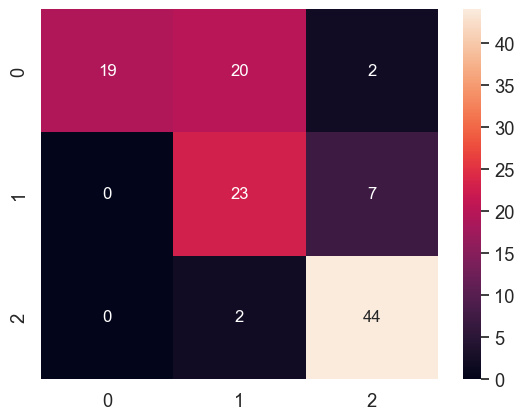

In [34]:
from sklearn.metrics import confusion_matrix

# np.reshape(y_test,(-1,1))
# np.reshape(y_train,(-1,1))
# print(np.shape(y_pred),np.shape(y_test))
# def oec(y_test):
#     _y_t = []
#     for it1 in y_test:
#         if it1 == 0:
#             _y_t.append([1,0,0])
#         elif it1 == 1:
#             _y_t.append([0,1,0])
#         else:
#             _y_t.append([0,0,1])
#     return _y_t

# _y_t = np.array(oec(y_test))
# _y_p = np.array(oec(y_pred))

cm = confusion_matrix(y_test_v, y_pred_v)

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [35]:
from sklearn.metrics import classification_report

print(classification_report(y_test_v, y_pred_v))

              precision    recall  f1-score   support

           0       1.00      0.46      0.63        41
           1       0.51      0.77      0.61        30
           2       0.83      0.96      0.89        46

    accuracy                           0.74       117
   macro avg       0.78      0.73      0.71       117
weighted avg       0.81      0.74      0.73       117



In [37]:
y_pred = "463.264 814.248 457.775 580.547 451.065 347.351 508.747 635.869 463.499 457.263 552.272 334.006 261.441 398.081 410.581 470.239 350.646 466.324 407.66  418.724 355.047 412.786 443.148 831.343 292.506 349.292 335.212 636.008 569.134 475.2   521.923 360.797 239.092 498.904 424.073 477.957 462.725 912.237 540.671 198.489 519.69  530.6   574.971 252.235 226.552 365.706 872.865 325.687 443.395 354.973 306.878 238.338 449.665 276.298 590.226 386.532 562.945 367.494 412.952 346.932 751.711 317.454 305.991 208.846 626.593 248.816 297.006 832.731 252.904 526.651 220.279 427.846 429.833 412.543 351.937 178.714 578.936 611.275 263.5 503.977 418.552 384.441 532.324 327.259 619.69 414.629 518.152 417.252 568.494 818.689 421.674 317.733 581.214 371.492 298.73 328.975 519.337 374.995 588.372 454.405 681.485 321.761 522.522 270.774 826.812 311.31 740.763 415.033 471.135 300.903 369.949 539.499 483.918 294.992 640.771 525.725 284.034"